In [78]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# initial plotting and plot styling libraries (will be overriden)
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


# statistical modeling libraries
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model


# jupyter wdgets
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image


# jupyter theme overrides
from jupyterthemes import jtplot
# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='chesterish')
# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.figsize'] = (16, 8)
# recet to matplotlib standards
#jtplot.reset()

# matplotlib overrides
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

# Time Series Forecasting wih Prophet

Prophet is a procedure for forecasting time series data. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with <strong>daily periodicity data</strong> with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers. - <a href="https://facebookincubator.github.io/prophet/">Prophet</a>

## The Model

Forecasting in the domain of Prophet is a curve-fitting task. The underlying model has an additive form

$$
y(t) = d(t) + s(t) + h(t) + \varepsilon_t
$$

where $d(t)$ denotes a trend function modeling non-periodic changes, $s(t)$ denotes seasonality modeling periodic changes and $h(t)$ representing the effects of holidays. This model assumes time as its only regressor, however, linear and non-linear transformations are included if it increases the models fit. Hence, 

In [2]:
from fbprophet import Prophet

The input to Prophet is always a dataframe with two columns: <code>ds</code> and <code>y</code>. The <code>ds</code> (datestamp) column must contain a date or datetime (either is fine). The <code>y</code> column must be numeric, and represents the measurement to forecast.

In [3]:
df = pd.read_csv('./data/passengers.csv', sep=';', header=0, parse_dates=True)

# create new coumns, specific headers needed for Prophet
df['ds'] = df['month']
df['y'] = pd.DataFrame(df['n_passengers'])
df.pop('month')
df.pop('n_passengers')

0      112
1      118
2      132
3      129
4      121
5      135
6      148
7      148
      ... 
136    472
137    535
138    622
139    606
140    508
141    461
142    390
143    432
Name: n_passengers, Length: 144, dtype: int64

<code>Prophet</code> assume an additive  time series model and thus, the data is transformed using the log operator of <code>numpy</code>.

In [4]:
df['y'] = pd.DataFrame(np.log(df['y']))
df.head()

,ds,y
0,1949-01,4.71850
1,1949-02,4.77068
2,1949-03,4.88280
3,1949-04,4.85981
4,1949-05,4.79579


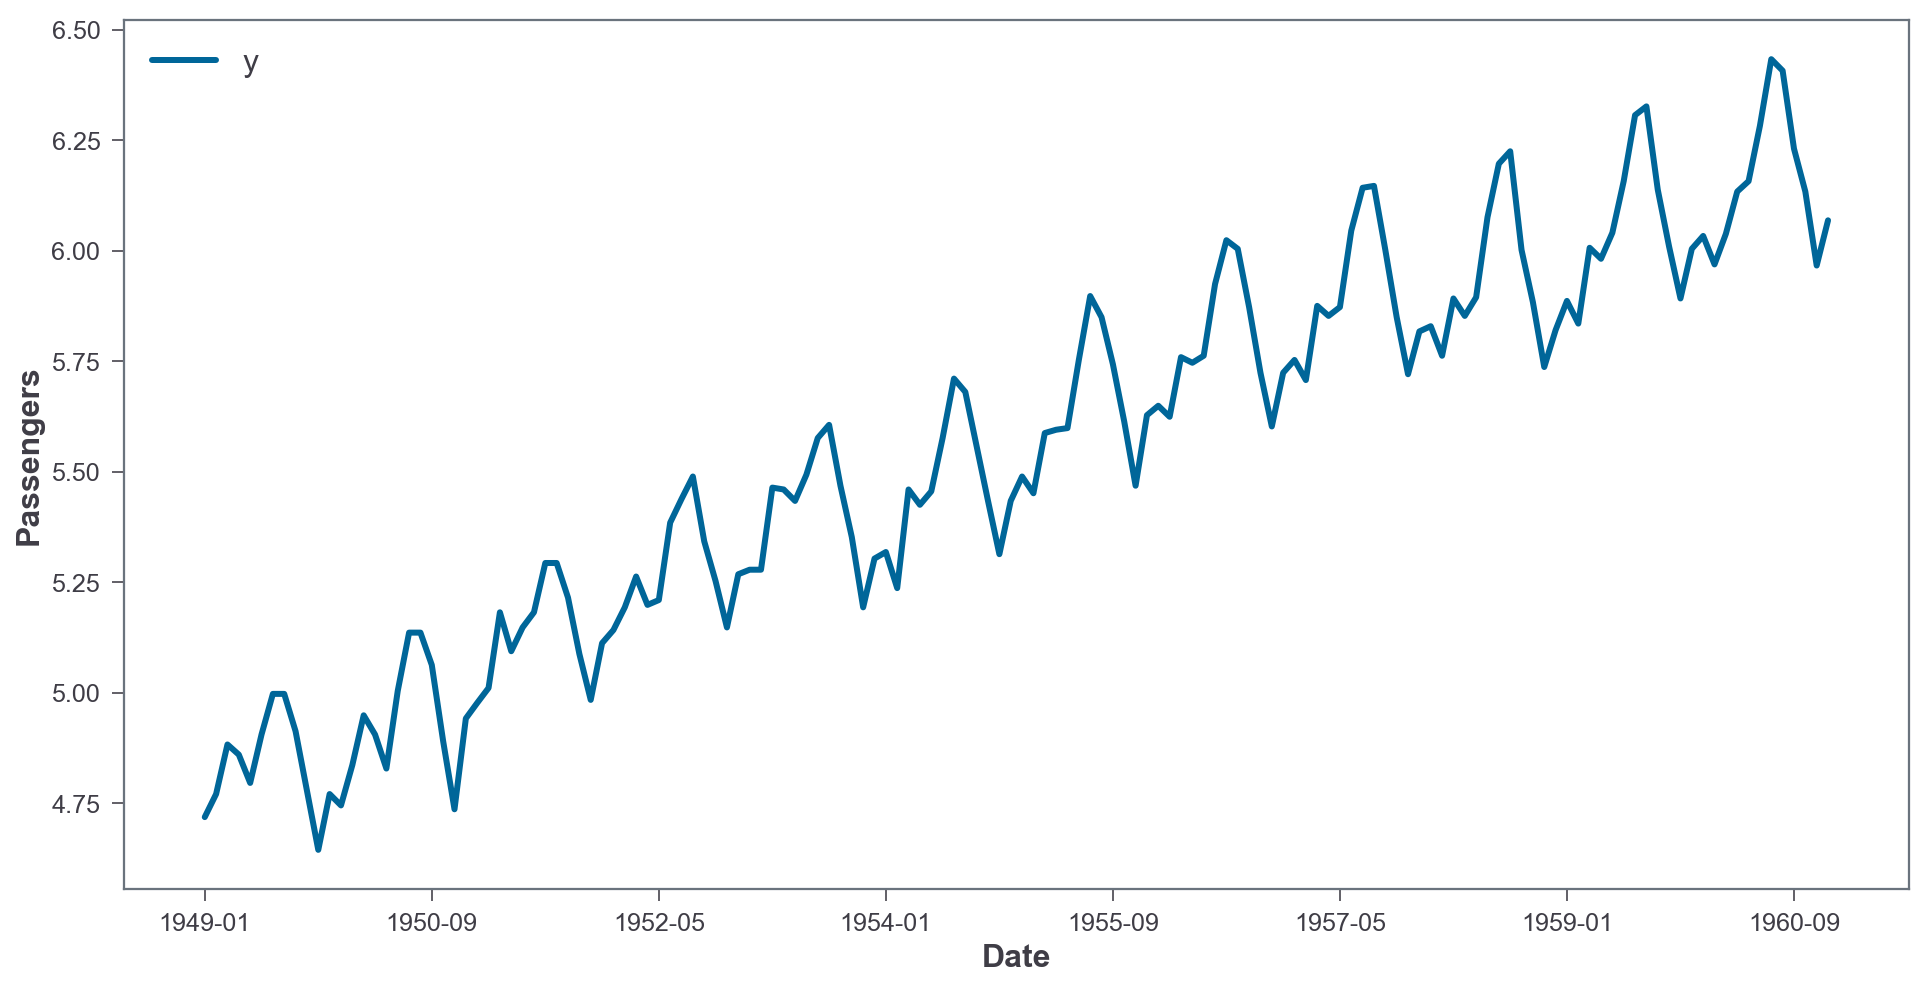

In [80]:
# log transform data
df['y'] = pd.DataFrame(np.log(df['y']))

# plot data
ax = df.set_index('ds').plot(color='#006699');
ax.set_ylabel('Passengers');
ax.set_xlabel('Date');
plt.savefig('./img/log_transformed_passenger.png')
plt.show()

In [6]:
# train test split
df_train = df[:120]
df_test = df[120:]

In [7]:
# instantiate the Prophet class
mdl = Prophet(interval_width=0.95)

In [8]:
# fit the model on the training data
mdl.fit(df_train)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
# define future time frame
future = mdl.make_future_dataframe(periods=24, freq='MS')
future.tail()

,ds
139,1960-08-01
140,1960-09-01
141,1960-10-01
142,1960-11-01
143,1960-12-01


The <code>predict</code> method assigns each row in future a predicted value <code>yhat</code>.

In [10]:
# generate the forecast
forecast = mdl.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
139,1960-08-01,6.27984,6.15677,6.40865
140,1960-09-01,6.13677,6.00941,6.28504
141,1960-10-01,6.01055,5.88168,6.16515
142,1960-11-01,5.88457,5.74329,6.04917
143,1960-12-01,5.99797,5.83933,6.15461


<code>mdl</code> is a <code>Prophet</code> object and and can be plotted with predefined settings

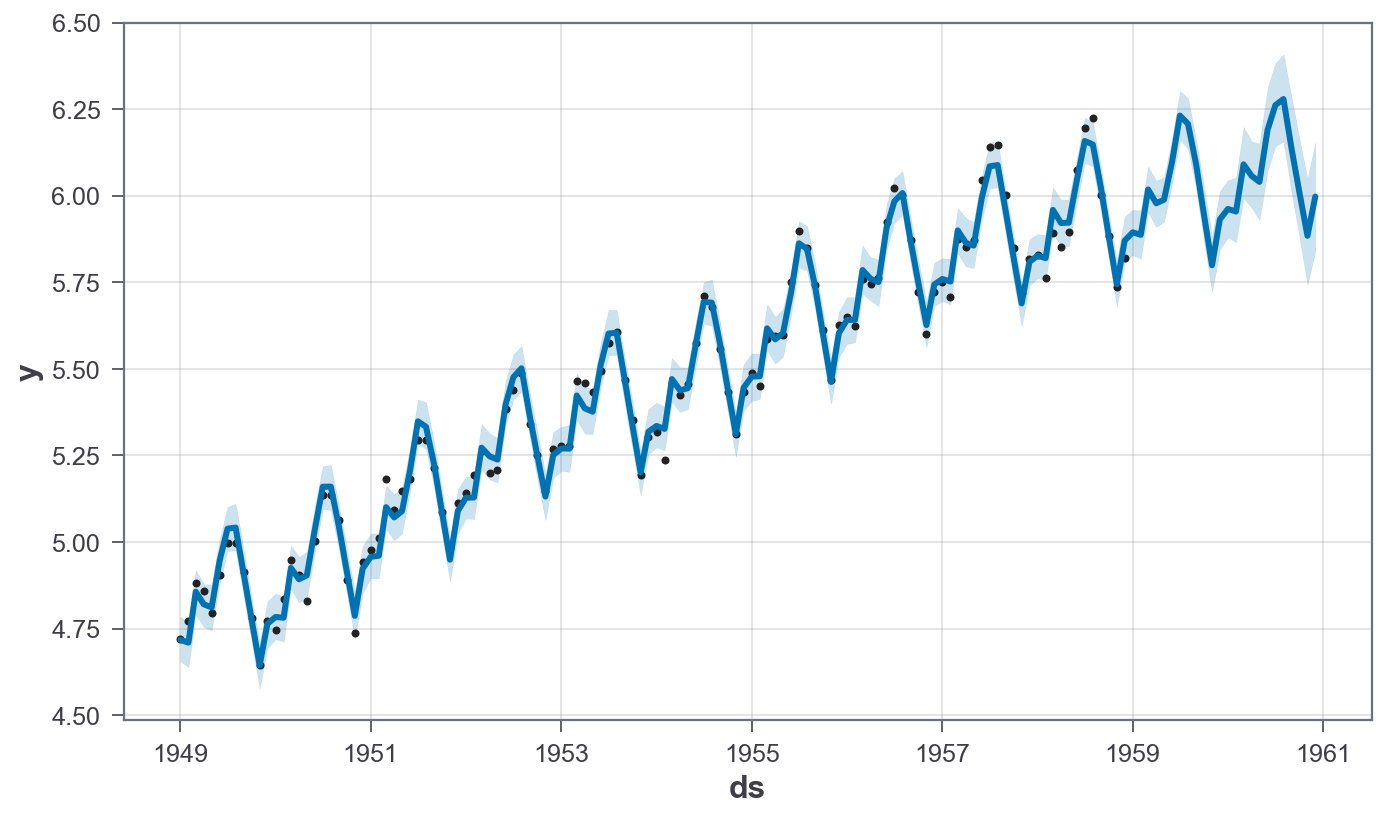

In [81]:
mdl.plot(forecast);
plt.savefig('./img/prophet_plot.png')
plt.show()

Similar to the <code>statsmodels</code> module a time series decomposition method is available.

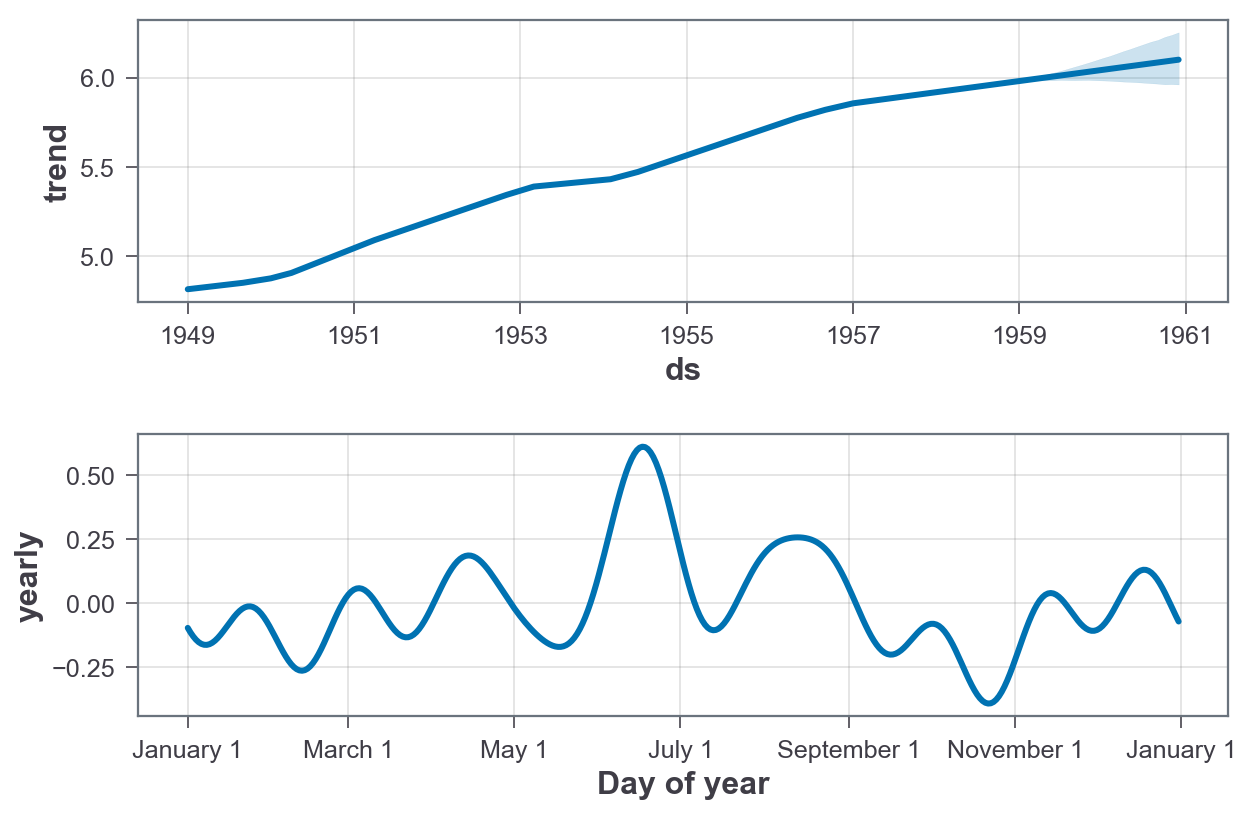

In [82]:
# plot time series components
mdl.plot_components(forecast);
plt.savefig('./img/prophet_decomp.png')
plt.show()

In [28]:
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,yearly,yearly_lower,yearly_upper,yhat
0,1949-01-01,4.81273,4.81273,4.81273,4.65520,4.78410,-0.09531,-0.09531,-0.09531,-0.09531,-0.09531,-0.09531,-0.09531,-0.09531,-0.09531,4.71742
1,1949-02-01,4.81734,4.81734,4.81734,4.63833,4.76657,-0.10797,-0.10797,-0.10797,-0.10797,-0.10797,-0.10797,-0.10797,-0.10797,-0.10797,4.70937
2,1949-03-01,4.82151,4.82151,4.82151,4.79070,4.91846,0.03485,0.03485,0.03485,0.03485,0.03485,0.03485,0.03485,0.03485,0.03485,4.85636
3,1949-04-01,4.82612,4.82612,4.82612,4.75374,4.87835,-0.00623,-0.00623,-0.00623,-0.00623,-0.00623,-0.00623,-0.00623,-0.00623,-0.00623,4.81989
4,1949-05-01,4.83058,4.83058,4.83058,4.74564,4.87722,-0.01945,-0.01945,-0.01945,-0.01945,-0.01945,-0.01945,-0.01945,-0.01945,-0.01945,4.81113
5,1949-06-01,4.83519,4.83519,4.83519,4.88133,5.00944,0.11202,0.11202,0.11202,0.11202,0.11202,0.11202,0.11202,0.11202,0.11202,4.94721
6,1949-07-01,4.83965,4.83965,4.83965,4.97384,5.10140,0.19887,0.19887,0.19887,0.19887,0.19887,0.19887,0.19887,0.19887,0.19887,5.03852
7,1949-08-01,4.84427,4.84427,4.84427,4.97672,5.11035,0.19750,0.19750,0.19750,0.19750,0.19750,0.19750,0.19750,0.19750,0.19750,5.04176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,1960-05-01,6.06357,5.97598,6.15962,5.93023,6.15160,-0.02316,-0.02316,-0.02316,-0.02316,-0.02316,-0.02316,-0.02316,-0.02316,-0.02316,6.04041


In [23]:
# retransform using e
y_hat = np.exp(forecast['yhat'][120:])
y_hat_lower = np.exp(forecast['yhat_lower'][120:])
y_hat_upper = np.exp(forecast['yhat_upper'][120:])
y_true = np.exp(df_test['y'])

# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 1610.75 MSE (40.13 RMSE)


In [61]:
# prepare data for plotting
months = pd.date_range(start='1959-01-01', end='1960-12-01', freq='MS')
#.reindex(pd.date_range(start='1959-01-01', end='1960-12-01', freq='MS'))
#.reindex(pd.date_range(start='1949-01-01', end='1960-12-01', freq='MS'))
y_hat_plot = pd.DataFrame(y_hat)
y_hat_lower_plot = pd.DataFrame(y_hat_lower)
y_hat_upper_plot = pd.DataFrame(y_hat_upper)
y_true_plot = pd.DataFrame(np.exp(df['y']))

In [93]:
pd.date_range(start='1958-12-01', end='1960-12-01', freq='MS')

DatetimeIndex(['1958-12-01', '1959-01-01', '1959-02-01', '1959-03-01',
               '1959-04-01', '1959-05-01', '1959-06-01', '1959-07-01',
               '1959-08-01', '1959-09-01', '1959-10-01', '1959-11-01',
               '1959-12-01', '1960-01-01', '1960-02-01', '1960-03-01',
               '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01',
               '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01',
               '1960-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [97]:
y_hat_upper

120   387.57725
121   386.89390
122   439.49307
123   421.19429
124   425.84611
125   476.92090
126   545.98594
127   535.02652
         ...   
136   469.46580
137   551.14967
138   592.05499
139   607.07095
140   536.48432
141   475.87208
142   423.75980
143   470.88156
Name: yhat_upper, Length: 24, dtype: float64

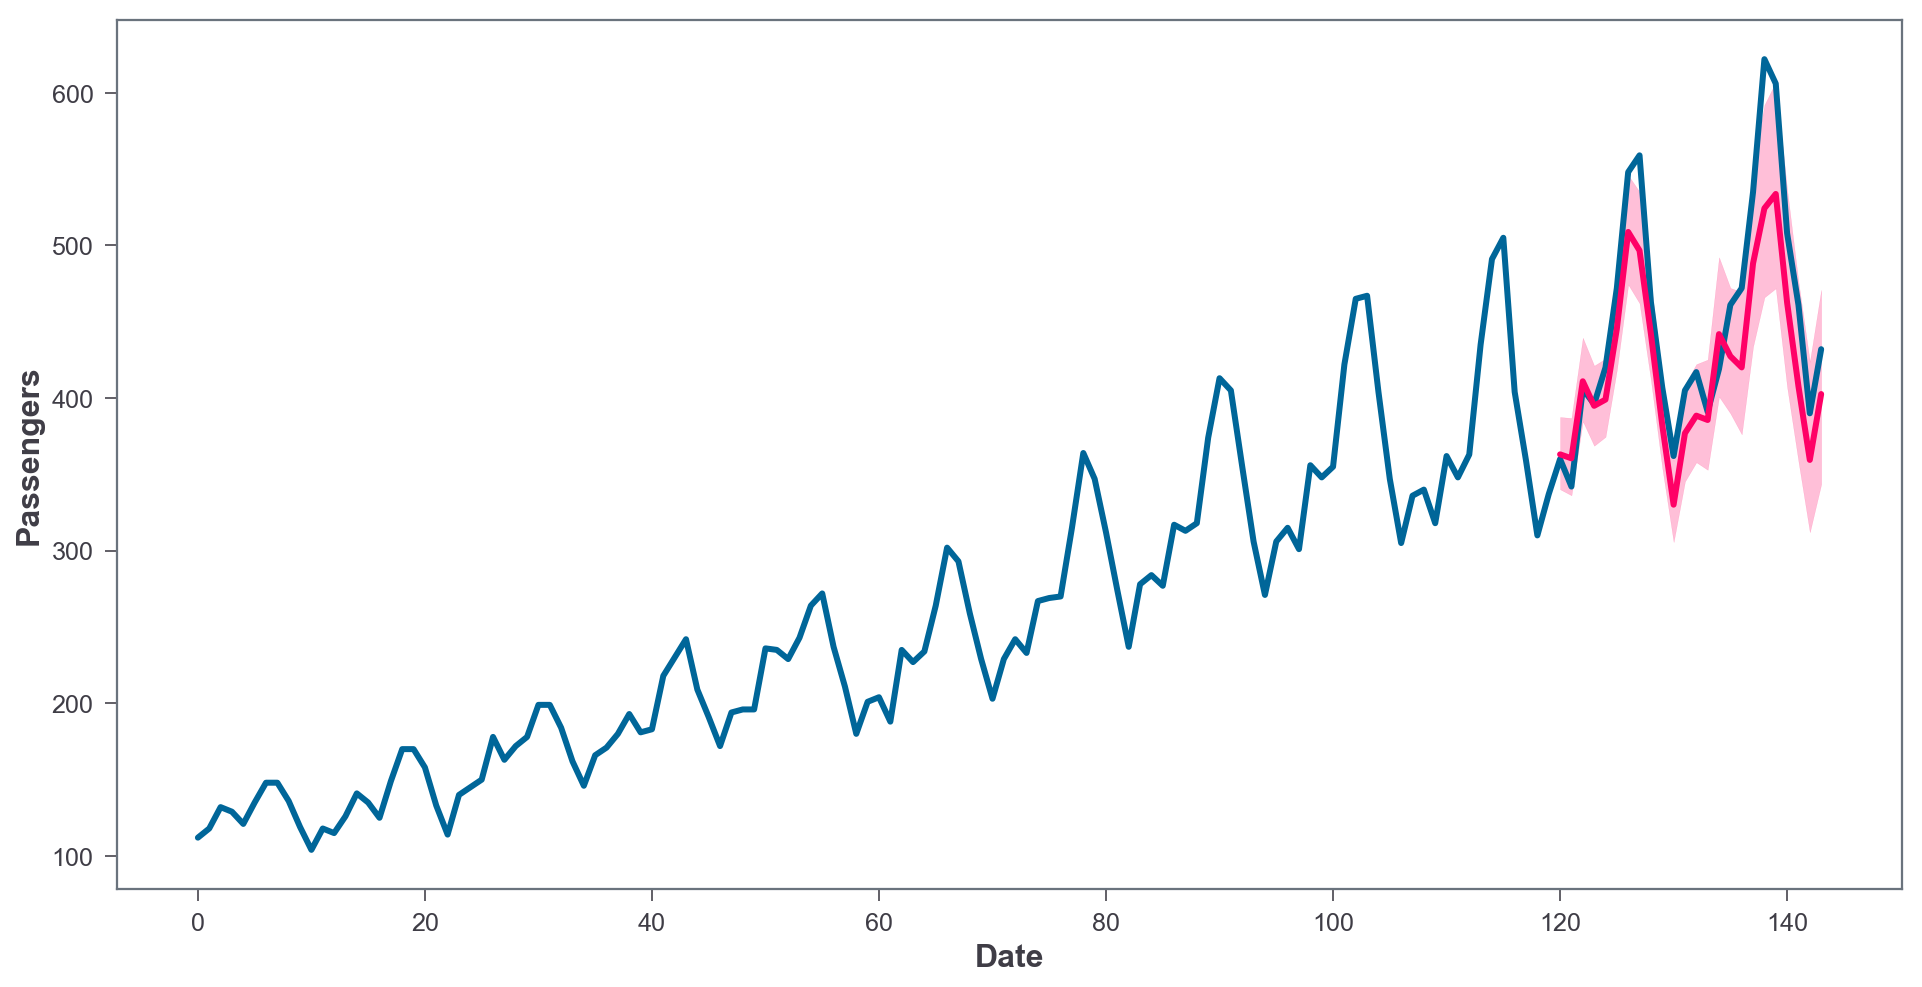

In [110]:
plt.plot(y_true_plot, label='Original', color='#006699');
plt.plot(y_hat_plot, color='#ff0066', label='Forecast');
plt.fill_between(y_true_plot[120:].index, y_hat_upper, y_hat_lower, color='#ff0066', alpha=0.25)
plt.ylabel('Passengers');
plt.xlabel('Date');
plt.savefig('./img/prophet_forecast.png')
plt.show()